# 参数管理

访问参数，用于调试、诊断和可视化。

参数初始化。

在不同模型组件间共享参数。

In [1]:
import torch
from torch import nn

In [9]:
# 单隐藏层的多层感知机
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1339],
        [-0.2657]], grad_fn=<AddmmBackward>)

In [10]:
net, X

(Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=1, bias=True)
 ),
 tensor([[0.8121, 0.7904, 0.4907, 0.4811],
         [0.6719, 0.0528, 0.5348, 0.7725]]))

## 1、参数访问

通过索引来访问模型的任意层。

In [11]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.3283, -0.1694, -0.2473,  0.3076,  0.2016,  0.0233,  0.1873, -0.1118]])), ('bias', tensor([-0.1285]))])


In [15]:
len(net), net[0], net[1], net[2]

(3,
 Linear(in_features=4, out_features=8, bias=True),
 ReLU(),
 Linear(in_features=8, out_features=1, bias=True))

### 目标参数
对参数执行任何操作，首先我们需要访问底层的数值。

参数是复合的对象，包含值、梯度和额外信息。

In [22]:
# 从第二个神经网络层提取偏置，提取后返回的是一个参数类实例，
# 并进一步访问该参数的值。
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.1285], requires_grad=True)
tensor([-0.1285])


访问每个参数的梯度。由于我们还没有调用这个网络的反向传播，所以参数的梯度处于初始状态。

In [23]:
net[2].weight.grad == None

True

### 访问所有参数
递归整个树来提取每个子块的参数。

In [24]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))


In [25]:
print(*[(name, param.shape) for name, param in net.named_parameters()])

('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [26]:
net.state_dict()['2.bias'].data

tensor([-0.1285])

### 从嵌套快收集参数

将多个块相互嵌套。

In [31]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), 
                         nn.ReLU(), 
                         nn.Linear(8, 4), 
                         nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.3236],
        [0.3236]], grad_fn=<AddmmBackward>)

In [32]:
rgnet

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)

In [35]:
rgnet[0][1][0].bias.data

tensor([-0.3964, -0.2791, -0.1332, -0.4022,  0.2257,  0.3366, -0.4615,  0.2114])

## 2、参数初始化

默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，这个范围是根据输入和输出维度计算出的。PyTorch的nn.init模块提供了多种预置初始化方法。

### 内置初始化
调用内置的初始化器。下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量，且将偏置参数设置为0。

In [37]:
def init_normal(m):
    if  type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

In [40]:
net, net.apply(init_normal), len(net), net[0].weight.data, net[0].bias.data

(Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=1, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=1, bias=True)
 ),
 3,
 tensor([[-0.0066,  0.0022, -0.0045, -0.0059],
         [ 0.0009,  0.0016,  0.0007, -0.0110],
         [-0.0097, -0.0099,  0.0123,  0.0150],
         [-0.0077, -0.0098, -0.0152,  0.0154],
         [-0.0060,  0.0241, -0.0156, -0.0001],
         [ 0.0159, -0.0135,  0.0085, -0.0092],
         [-0.0119,  0.0094, -0.0060, -0.0109],
         [-0.0046,  0.0162,  0.0148,  0.0057]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [41]:
# 将所有参数初始化为给定的常数
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

In [43]:
net.apply(init_constant), net[0].weight.data, net[0].bias.data

(Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=1, bias=True)
 ),
 tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [44]:
# 对某些块应用不同的初始化方法
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

In [46]:
net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data)
print(net[2].weight.data)

tensor([[ 0.1867,  0.5242,  0.3409,  0.3975],
        [-0.4466, -0.5160, -0.0717,  0.1793],
        [ 0.2146, -0.5885, -0.5857,  0.2438],
        [-0.3259, -0.3884, -0.2931, -0.5992],
        [-0.0056,  0.6317,  0.5868, -0.5858],
        [ 0.0360, -0.3534,  0.3174,  0.0681],
        [ 0.1829, -0.1901,  0.4776,  0.5632],
        [ 0.5257, -0.5704, -0.0254,  0.3652]])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### 自定义初始化
用以下的分布为任意权重参数 w 定义初始化方法：
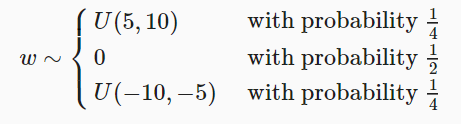

In [58]:
def my_init(m):
    if type(m) == nn.Linear:
        print(
            "Init",
            *[(name, param.shape) for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5  

In [59]:
net.apply(my_init), net[0].weight.data

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


(Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=1, bias=True)
 ),
 tensor([[ 0.0000, -0.0000, -6.0845,  0.0000],
         [-7.4225, -0.0000,  7.3904,  6.4162],
         [ 0.0000,  9.0256, -0.0000, -7.3118],
         [ 0.0000, -7.9844, -8.3726, -5.4523],
         [-6.4323,  0.0000,  0.0000,  8.3616],
         [-5.8720,  9.7609,  7.5696,  0.0000],
         [-9.4049, -0.0000,  0.0000,  0.0000],
         [-0.0000, -0.0000,  0.0000, -0.0000]]))

In [60]:
# 可直接设置参数
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000, -5.0845,  1.0000])

## 3、参数绑定
在多个层间共享参数。

定义一个稠密层，然后使用它的参数来设置另一个层的参数。

这个例子表明第二层和第三层的参数是绑定的。它们不仅值相等，而且由相同的张量表示。因此，如果我们改变其中一个参数，另一个参数也会改变。

参数绑定时，梯度变化：由于模型参数包含梯度，因此在反向传播期间第二个隐藏层和第三个隐藏层的梯度会加在一起。

In [66]:
# 我们需要给共享层一个名称，以便可以引用它的参数。
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), shared, nn.ReLU(), shared,
                    nn.ReLU(), nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值。
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


In [67]:
net, net(X)

(Sequential(
   (0): Linear(in_features=4, out_features=8, bias=True)
   (1): ReLU()
   (2): Linear(in_features=8, out_features=8, bias=True)
   (3): ReLU()
   (4): Linear(in_features=8, out_features=8, bias=True)
   (5): ReLU()
   (6): Linear(in_features=8, out_features=1, bias=True)
 ),
 tensor([[-0.4075],
         [-0.3829]], grad_fn=<AddmmBackward>))

共享参数通常可以节省内存，并在以下方面具有特定的好处：

    对于图像识别中的CNN，共享参数使网络能够在图像中的任何地方而不是仅在某个区域中查找给定的功能。
    对于RNN，它在序列的各个时间步之间共享参数，因此可以很好地推广到不同序列长度的示例。
    对于自动编码器，编码器和解码器共享参数。 在具有线性激活的单层自动编码器中，共享权重会在权重矩阵的不同隐藏层之间强制正交。